In [1]:
# !pip install svgwrite svgpathtools
# !pip install cairosvg bitsandbytes
# !pip install git+https://github.com/openai/CLIP.git
# !pip install -q opencv-python scikit-image pillow
# !pip install scour cssutils

In [2]:
#| default_exp core

In [3]:
#| export

import kagglehub
import shutil
import os
import sys
from pathlib import Path
import subprocess

# diffvg_path = kagglehub.dataset_download('tomirol/diffvg')
# out_path = Path("/tmp/diffvg").resolve()

# if not out_path.exists():
#     shutil.copytree(Path(diffvg_path) / "diffvg", str(out_path))
#     output = subprocess.check_output(f"pip uninstall tensorflow -y && cd {str(out_path)} && python setup.py install", shell=True, text=True)

# sys.path.append(str(out_path / "dist/diffvg-0.0.1-py3.10-linux-x86_64.egg"))


In [4]:
#| export

draw_src_path = kagglehub.dataset_download('tomirol/drawsrc')

out_path = Path("/tmp/drawsrc")

if not out_path.exists():
    shutil.copytree(str(draw_src_path), out_path)

sys.path.append(str(out_path))

In [5]:
#| export

primitive_path = kagglehub.dataset_download('tomirol/primitive')

out_path = Path("/tmp/primitive")

if not out_path.exists():
    shutil.copy(Path(primitive_path) / "primitive", out_path)
    subprocess.check_output(f"chmod +x {out_path}", shell=True, text=True)

In [6]:
#| export

import sys
import site
from importlib import invalidate_caches

# Refresh sys.path
site.main()
invalidate_caches()

In [7]:
#| export

# import os
# os.environ["TORCH_COMPILE_DISABLE"] = "1"

from pydantic import BaseModel
from PIL import Image
import re
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
import kagglehub
import subprocess
import scour.scour


import os
import kornia
import torch.nn as nn
import copy
import random
import pandas as pd
import cv2
import json
import cairosvg
from pathlib import Path
import io
from torch.nn import functional as F
import numpy as np
import torch
from tqdm.auto import tqdm
import pydiffvg


from src.score_original import VQAEvaluator, ImageProcessor, AestheticEvaluator
from src.score_gradient import (
    score_original,
    score_gradient,
    aesthetic_score_original,
    vqa_score_original,
    aesthetic_score_gradient,
    vqa_score_gradient,
)
from src.preprocessing import apply_preprocessing_torch

from src.text_to_svg import text_to_svg


device_0 = f"cuda:{max(0, torch.cuda.device_count() - 2)}"
device_1 = f"cuda:{max(0, torch.cuda.device_count() - 1)}"

In [8]:
#| export


class BaseConfig(BaseModel):
    width: int = 384
    height: int = 384

class SDConfig(BaseConfig):
    stable_diffusion_path: str = kagglehub.model_download("stabilityai/stable-diffusion-v2/pytorch/1/1")
    
    # prompt_prefixes: list[str] = ["Simple, classic image of"]
    # prompt_suffixes: list[str] = ["with flat color blocks, beautiful, minimal details, solid colors only"]
    # negative_prompts: list[str] = ["lines, framing, hatching, background, textures, patterns, details, outlines"]

    prompt_prefixes: list[str] = ["Simple, classic image of"]
    prompt_suffixes: list[str] = ["beautiful, minimal details, avoid other colors"]
    negative_prompts: list[str] = ["other colors, detailed"]

    num_inference_steps: int = 25
    guidance_scale: int = 20


class TextConfig(BaseConfig):
    x_position_frac: float = 0.9
    y_position_frac: float = 0.9
    font_size: int = 45
    color: tuple[int, int, int] = (255, 255, 255)
    font_path: str = ""


class PrimitiveConfig(BaseConfig):
    mode: int = 8
    num_shapes: int = 100


class DiffvgConfig(BaseConfig):
    num_iterations: int = 40
    validation_steps: int = 20
    # base_svg_path: str = str(Path(kagglehub.dataset_download('tomirol/aestsvg')) / "default_aest_0500.svg")
    base_svg_path: str = str(Path(kagglehub.dataset_download('tomirol/aestsvg')) / "output_aest_650.svg")
    # base_svg_path: str = str(Path(kagglehub.dataset_download('tomirol/aestsvg')) / "output_aest_144_0.702.svg")
    # base_svg_path: str = str(Path(kagglehub.dataset_download('tomirol/aestsvg')) / "output_aest_48_0.593.svg")


In [9]:
# -*- coding: utf-8 -*-
# Copyright (c) XiMing Xing. All rights reserved.
# Author: XiMing Xing
# Description:

from typing import Callable, List, Optional, Union, Tuple

import torch
import torch.nn.functional as F
from torch.cuda.amp import custom_bwd, custom_fwd
from torchvision import transforms
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
from diffusers.pipelines.stable_diffusion import StableDiffusionPipeline
from diffusers.schedulers.scheduling_pndm import PNDMScheduler


class LSDSPipeline(StableDiffusionPipeline):
    r"""
    Pipeline for text-to-image generation using Stable Diffusion.
    This model inherits from [`DiffusionPipeline`]. Check the superclass documentation for the generic methods the
    library implements for all the pipelines (such as downloading or saving, running on a particular device, etc.)
    Args:
        vae ([`AutoencoderKL`]):
            Variational Auto-Encoder (VAE) Model to encode and decode images to and from latent representations.
        text_encoder ([`CLIPTextModel`]):
            Frozen text-encoder. Stable Diffusion uses the text portion of
            [CLIP](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel), specifically
            the [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14) variant.
        tokenizer (`CLIPTokenizer`):
            Tokenizer of class
            [CLIPTokenizer](https://huggingface.co/docs/transformers/v4.21.0/en/model_doc/clip#transformers.CLIPTokenizer).
        unet ([`UNet2DConditionModel`]): Conditional U-Net architecture to denoise the encoded image latents.
        scheduler ([`SchedulerMixin`]):
            A scheduler to be used in combination with `unet` to denoise the encoded image latents. Can be one of
            [`DDIMScheduler`], [`LMSDiscreteScheduler`], or [`PNDMScheduler`].
        safety_checker ([`StableDiffusionSafetyChecker`]):
            Classification module that estimates whether generated images could be considered offensive or harmful.
            Please, refer to the [model card](https://huggingface.co/runwayml/stable-diffusion-v1-5) for details.
        feature_extractor ([`CLIPFeatureExtractor`]):
            Model that extracts features from generated images to be used as inputs for the `safety_checker`.
    """
    _optional_components = ["safety_checker", "feature_extractor"]

    @torch.no_grad()
    def __call__(
            self,
            prompt: Union[str, List[str]],
            height: Optional[int] = None,
            width: Optional[int] = None,
            num_inference_steps: int = 50,
            guidance_scale: float = 7.5,
            negative_prompt: Optional[Union[str, List[str]]] = None,
            num_images_per_prompt: Optional[int] = 1,
            eta: float = 0.0,
            generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
            latents: Optional[torch.FloatTensor] = None,
            output_type: Optional[str] = "pil",
            return_dict: bool = True,
            callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
            callback_steps: Optional[int] = 1,
    ):
        r"""
        Function invoked when calling the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`):
                The prompt or prompts to guide the image generation.
            height (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The width in pixels of the generated image.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. Ignored when not using guidance (i.e., ignored
                if `guidance_scale` is less than `1`).
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [`schedulers.DDIMScheduler`], will be ignored for others.
            generator (`torch.Generator`, *optional*):
                One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
                to make generation deterministic.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
                plain tuple.
            callback (`Callable`, *optional*):
                A function that will be called every `callback_steps` steps during inference. The function will be
                called with the following arguments: `callback(step: int, timestep: int, latents: torch.FloatTensor)`.
            callback_steps (`int`, *optional*, defaults to 1):
                The frequency at which the `callback` function will be called. If not specified, the callback will be
                called at every step.

        Returns:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] or `tuple`:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] if `return_dict` is True, otherwise a `tuple.
            When returning a tuple, the first element is a list with the generated images, and the second element is a
            list of `bool`s denoting whether the corresponding generated image likely represents "not-safe-for-work"
            (nsfw) content, according to the `safety_checker`.
        """

        # 0. Default height and width to unet
        height = height or self.unet.config.sample_size * self.vae_scale_factor
        width = width or self.unet.config.sample_size * self.vae_scale_factor

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(prompt, height, width, callback_steps)

        # 2. Define call parameters
        batch_size = 1 if isinstance(prompt, str) else len(prompt)
        device = self._execution_device
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        text_embeddings = self._encode_prompt(
            prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
        )

        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = self.scheduler.timesteps

        # 5. Prepare latent variables
        try:
            num_channels_latents = self.unet.config.in_channels
        except Exception or Warning:
            num_channels_latents = self.unet.in_channels

        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            text_embeddings.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. inherit TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, latents)

        # 8. Post-processing
        image = self.decode_latents(latents)

        # image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]
        # do_denormalize = [True] * image.shape[0]
        # image = self.image_processor.postprocess(image, output_type=output_type, do_denormalize=do_denormalize)

        # 9. Run safety checker
        has_nsfw_concept = None
        # image, has_nsfw_concept = self.run_safety_checker(image, device, text_embeddings.dtype)

        # 10. Convert to PIL
        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)

    def encode_(self, images):
        images = (2 * images - 1).clamp(-1.0, 1.0)  # images: [B, 3, H, W]

        # encode images
        latents = self.vae.encode(images).latent_dist.sample()
        latents = self.vae.config.scaling_factor * latents

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma

        return latents

    def x_augment(self, x: torch.Tensor, img_size: int = 512):
        augment_compose = transforms.Compose([
            transforms.RandomPerspective(distortion_scale=0.5, p=0.7),
            transforms.RandomCrop(size=(img_size, img_size), pad_if_needed=True, padding_mode='reflect')
        ])
        return augment_compose(x)

    def score_distillation_sampling(self,
                                    pred_rgb: torch.Tensor,
                                    im_size: int,
                                    prompt: Union[List, str],
                                    negative_prompt: Union[List, str] = None,
                                    guidance_scale: float = 100,
                                    as_latent: bool = False,
                                    grad_scale: float = 1,
                                    t_range: Union[List[float], Tuple[float]] = (0.05, 0.95)):
        num_train_timesteps = self.scheduler.config.num_train_timesteps
        min_step = int(num_train_timesteps * t_range[0])
        max_step = int(num_train_timesteps * t_range[1])
        alphas = self.scheduler.alphas_cumprod.to(self.device)  # for convenience

        # input augmentation
        pred_rgb_a = self.x_augment(pred_rgb, im_size)

        # the input is intercepted to im_size x im_size and then fed to the vae
        if as_latent:
            latents = F.interpolate(pred_rgb_a, (64, 64), mode='bilinear', align_corners=False) * 2 - 1
        else:
            # encode image into latents with vae, requires grad!
            latents = self.encode_(pred_rgb_a)

        #  Encode input prompt
        num_images_per_prompt = 1  # the number of images to generate per prompt
        do_classifier_free_guidance = guidance_scale > 1.0
        text_embeddings = self._encode_prompt(
            prompt, self.device, num_images_per_prompt,
            do_classifier_free_guidance,
            negative_prompt=negative_prompt,
        )

        # timestep ~ U(0.05, 0.95) to avoid very high/low noise level
        t = torch.randint(min_step, max_step + 1, [1], dtype=torch.long, device=self.device)

        # predict the noise residual with unet, stop gradient
        with torch.no_grad():
            # add noise
            noise = torch.randn_like(latents)
            latents_noisy = self.scheduler.add_noise(latents, noise, t)
            # pred noise
            latent_model_input = torch.cat([latents_noisy] * 2) if do_classifier_free_guidance else latents_noisy
            noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance (high scale from paper!)
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_pos = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_pos - noise_pred_uncond)

        # w(t), sigma_t^2
        w = (1 - alphas[t])
        grad = grad_scale * w * (noise_pred - noise)
        grad = torch.nan_to_num(grad)

        # since we omitted an item in grad, we need to use the custom function to specify the gradient
        loss = SpecifyGradient.apply(latents, grad)

        return loss, grad.mean()


class SpecifyGradient(torch.autograd.Function):

    @staticmethod
    @custom_fwd
    def forward(ctx, input_tensor, gt_grad):
        ctx.save_for_backward(gt_grad)
        # we return a dummy value 1, which will be scaled by amp's scaler so we get the scale in backward.
        return torch.ones([1], device=input_tensor.device, dtype=input_tensor.dtype)

    @staticmethod
    @custom_bwd
    def backward(ctx, grad_scale):
        gt_grad, = ctx.saved_tensors
        gt_grad = gt_grad * grad_scale
        return gt_grad, None

/tmp/ipykernel_1270198/1554997518.py:289: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/tmp/ipykernel_1270198/1554997518.py:296: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [10]:
#| export

def generate_sd_image(pipe: StableDiffusionPipeline, prompt: str, config: SDConfig, num_images_per_prompt: int = 1) -> list[Image.Image]:
    all_images = []
    for prompt_prefix, prompt_suffix, negative_prompt in zip(config.prompt_prefixes, config.prompt_suffixes, config.negative_prompts):
        generator = torch.Generator(device="cuda").manual_seed(0)
        images = pipe(
            height=512,
            width=512,
            # prompt=f'a image of {prompt}',
            prompt=f'{prompt_prefix} {prompt} {prompt_suffix}',
            negative_prompt=negative_prompt,

            # prompt=[f"{prompt}. minimal flat 2d vector icon. lineal color. on a white background. trending on artstation"],
            # negative_prompt=None,

            num_inference_steps=config.num_inference_steps,
            guidance_scale=config.guidance_scale,
            generator=generator,
            num_images_per_prompt=num_images_per_prompt,
        ).images
        all_images += images
    return all_images

In [11]:
#| export

def generate_primitive_svg(
    image: Image.Image,
    size: int = 384,
    mode: int = 8,
    num_shapes: int = 100,
    temp_path: str = "/tmp/image.png",
    max_size: int = 5500
) -> str:
    temp_path_svg = temp_path.replace(".png", ".svg")
    image = image.resize((size, size))

    image.save(temp_path)

    args = [
        "/tmp/primitive",
        "-i",
        temp_path,
        "-o",
        temp_path_svg,
        "-n",
        str(num_shapes),
        "-m",
        str(mode),
        "-r",
        f"{size}",
        "-s",
        f"{size}",
    ]
    subprocess.run(args)

    with open(temp_path_svg, "r") as f:
        svg = f.read()
    
    svg = polygon_to_path(svg)
    
    cur_svg = svg
    svg_lines = svg.strip().split("\n")
    keep_idx = [1] * len(svg_lines)
    cur_idx = len(svg_lines) - 1

    while len(optimize_svg(cur_svg).encode('utf-8')) > max_size:
        if "<path" in svg_lines[cur_idx]:
            keep_idx[cur_idx] = 0

        cur_idx -= 1
        cur_svg = "\n".join([line for i, line in enumerate(svg_lines) if keep_idx[i]])
        
    print(f"Avg keep: {np.mean(keep_idx)}")
    print(len(optimize_svg(cur_svg).encode('utf-8')))
    
    svg = cur_svg

    svg += text_to_svg("O", x_position_frac=0.75, y_position_frac=0.85, font_size=60, color=(255, 255, 255), font_path="/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf").split("\n")[1]
    # svg += text_to_svg("O", x_position_frac=0.6, y_position_frac=0.85, font_size=60, color=(255, 255, 255), font_path="/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf").split("\n")[1]
    # svg += text_to_svg("C", x_position_frac=0.75, y_position_frac=0.85, font_size=60, color=(0, 0, 0), font_path="/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf").split("\n")[1]

    svg = svg.replace("</svg>", "") + "</svg>"

    return svg

In [12]:
#| export

def polygon_to_path(svg: str) -> str:
    svg = re.sub(
        r'<polygon([\w\W]+?)points=(["\'])([\.\d, -]+?)(["\'])', 
        r'<path\1d=\2M\3z\4', 
        svg
    )
    svg = re.sub(
        r'<polyline([\w\W]+?)points=(["\'])([\.\d, -]+?)(["\'])', 
        r'<path\1d=\2M\3\4', 
        svg
    )
    return svg

def merge_svgs(bg_svg: str, aest_svg: str):
    aest_svg = aest_svg.strip().split("\n")[2:-1]
    # aest_svg = aest_svg.strip().split("\n")[2:-2]
    
    # aest_svg = [
    #     '<g clip-path="polygon(32px 32px, 80px 32px, 80px 80px, 32px 80px)">',
    #     # '<svg x="32" y="32" width="48" height="48" viewBox="32 32 48 48" overflow="hidden">',
    #     *aest_svg,
    #     '</g>'
    # ]
    aest_svg = "\n".join(aest_svg)
    
    bg_svg = polygon_to_path(bg_svg)
    svg = bg_svg + '\n' + aest_svg
    svg = svg.replace("</svg>", "") + "</svg>"

    return svg


def svg_to_png_no_resize(svg_code: str) -> Image.Image:
    png_data = cairosvg.svg2png(bytestring=svg_code.encode('utf-8'))
    img_pil = Image.open(io.BytesIO(png_data)).convert('RGB')
    return img_pil


def apply_random_crop_resize_seed(image: Image.Image, crop_percent=0.05, seed=42):
    rs = np.random.RandomState(seed)
    
    width, height = image.size
    crop_pixels_w = int(width * crop_percent)
    crop_pixels_h = int(height * crop_percent)

    left = rs.randint(0, crop_pixels_w + 1)
    top = rs.randint(0, crop_pixels_h + 1)
    right = width - rs.randint(0, crop_pixels_w + 1)
    bottom = height - rs.randint(0, crop_pixels_h + 1)

    image = image.crop((left, top, right, bottom))
    image = image.resize((width, height), Image.BILINEAR)

    return image


def get_optimization_settings():
    settings = pydiffvg.SvgOptimizationSettings()

    lr = 5e-3

    settings.global_override(["optimizer"], "Adam")
    settings.global_override(["color_lr"], lr)
    settings.global_override(["alpha_lr"], lr)
    settings.global_override(["paths", "shape_lr"], 10*lr)
    settings.global_override(["circles", "shape_lr"], 10*lr)
    settings.global_override(["transforms", "transform_lr"], 10*lr)
    
    settings.global_override(["gradients", "optimize_stops"], True)
    settings.global_override(["gradients", "stop_lr"], lr)
    settings.global_override(["gradients", "optimize_color"], True)
    settings.global_override(["gradients", "color_lr"], lr)
    settings.global_override(["gradients", "optimize_alpha"], True)
    settings.global_override(["gradients", "alpha_lr"], lr)
    settings.global_override(["gradients", "optimize_location"], True)
    settings.global_override(["gradients", "location_lr"], 10*lr)

    settings.global_override(["optimize_color"], True)
    settings.global_override(["optimize_alpha"], True)
    settings.global_override(["paths", "optimize_points"], True)
    settings.global_override(["circles", "optimize_center"], True)
    settings.global_override(["circles", "optimize_radius"], True)
    settings.global_override(["transforms", "optimize_transforms"], True)

    return settings


def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False


def generate_diffvg_svg(
    bg_svg: str,
    base_svg_path: str,
    evaluator: AestheticEvaluator,
    width: int = 384,
    height: int = 384,
    num_iterations: int = 100,
    validation_steps: int = 10,
    device: str = device_0,
    num_eval: int = 4
) -> Image.Image:
    pydiffvg.set_use_gpu(True)

    bg_image = svg_to_png_no_resize(bg_svg)
    bg_image = bg_image.resize((width, height))
    bg_image = np.array(bg_image)
    bg_image = torch.from_numpy(bg_image).to(device).permute(2, 0, 1).float() / 255.0

    # mask = torch.zeros((3, height, width), dtype=torch.float32, device=device)
    # mask[:, 32:80, 32:80] = 1

    settings = get_optimization_settings()

    text_path_ids = [f"text-path-{i}" for i in range(100)] + [f"background-{i}" for i in range(10)]
    for text_id in text_path_ids:
        text_settings = settings.undefault(text_id)
        text_settings["paths"]["optimize_points"] = False
        text_settings["optimize_color"] = True
        text_settings["optimize_alpha"] = True
        text_settings["optimize_transforms"] = False

    optim_svg = pydiffvg.OptimizableSvg(
        base_svg_path, settings, optimize_background=False, verbose=False, device=device
    )

    best_svg = optimize_svg(merge_svgs(bg_svg, optim_svg.write_xml()))
    best_val_loss = -1e8
    
    grad_accumulation_steps = 1

    pbar = tqdm(total=num_iterations)

    for iter_idx in range(num_iterations):
        optim_svg.zero_grad()
        image = optim_svg.render(seed=iter_idx)
        img = image[:, :, :3].permute(2, 0, 1).clamp(0, 1)

        # img = img * mask + bg_image * (1 - mask)

        mask = (img == 0).all(dim=0).unsqueeze(0).float()
        img = (1.0 - mask) * img + mask * bg_image
        
        crop_frac = 0.05
        random_size = int(random.uniform(1.0 - crop_frac, 1.0) * image.shape[1])
        img = kornia.augmentation.RandomCrop((random_size, random_size))(img.unsqueeze(0)).squeeze(0)

        img = apply_preprocessing_torch(img)

        loss = aesthetic_score_gradient(evaluator, img).mean()

        if iter_idx == 0 or (iter_idx + 1) % validation_steps == 0:
            torch.cuda.empty_cache()
            
            aest_svg = optim_svg.write_xml()
            cur_svg = merge_svgs(bg_svg, aest_svg)
            cur_svg_opt = optimize_svg(cur_svg)
            pil_image = svg_to_png_no_resize(cur_svg_opt)
            val_loss = 0.0
            
            for eval_idx in range(num_eval):
                pil_image_eval = pil_image.copy()
                pil_image_eval = apply_random_crop_resize_seed(pil_image_eval, crop_percent=0.03, seed=eval_idx)
                pil_image_eval = ImageProcessor(pil_image_eval).apply().image
                val_loss += aesthetic_score_original(evaluator, pil_image_eval)

            val_loss /= num_eval

            # pil_image = Image.fromarray((img_bkp.detach().cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)).convert("RGB")

            if val_loss > best_val_loss:
                best_val_loss = val_loss
                best_svg = cur_svg_opt
            
        pbar.set_description(
            f"It {iter_idx}/{num_iterations} | "
            f"Loss: {loss.item():.3f} | "
            f"Val Loss: {val_loss:.3f} | "
        )
        pbar.update(1)

        loss = -loss / grad_accumulation_steps
        loss.backward()
        
        if (iter_idx + 1) % grad_accumulation_steps == 0:
            optim_svg.step()

    print(f"Best loss: {best_val_loss}")

    return best_svg

In [13]:
#| export

def optimize_svg(svg):
    options = scour.scour.parse_args([
        '--enable-viewboxing',
        '--enable-id-stripping',
        '--enable-comment-stripping',
        '--shorten-ids',
        '--indent=none',
        '--strip-xml-prolog',
        '--remove-metadata',
        '--remove-descriptive-elements',
        '--disable-embed-rasters',
        '--enable-viewboxing',
        '--create-groups',
        '--renderer-workaround',
        '--set-precision=2',
    ])

    svg = scour.scour.scourString(svg, options)
    
    svg = svg.replace('id=""', '')
    svg = svg.replace('version="1.0"', '')
    svg = svg.replace('version="1.1"', '')
    svg = svg.replace('version="2.0"', '')
    svg = svg.replace('  ', ' ')
    svg = svg.replace('>\n', '>')
    
    return svg

In [14]:
import ast
import io
import math
import statistics
import string

import cairosvg
import clip
import cv2
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from more_itertools import chunked
from PIL import Image, ImageFilter
from transformers import (
    AutoProcessor,
    BitsAndBytesConfig,
    PaliGemmaForConditionalGeneration,
)

svg_constraints = kagglehub.package_import('metric/svg-constraints', bypass_confirmation=True)


device_0 = f"cuda:{max(0, torch.cuda.device_count() - 2)}"
device_1 = device_0

class ParticipantVisibleError(Exception):
    pass


def score(
    solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, random_seed: int = 0
) -> float:
    """Calculates a fidelity score by comparing generated SVG images to target text descriptions.

    Parameters
    ----------
    solution : pd.DataFrame
        A DataFrame containing target questions, choices, and answers about an SVG image.
    submission : pd.DataFrame
        A DataFrame containing generated SVG strings. Must have a column named 'svg'.
    row_id_column_name : str
        The name of the column containing row identifiers. This column is removed before scoring.
    random_seed : int
        A seed to set the random state.

    Returns
    -------
    float
        The mean fidelity score (a value between 0 and 1) representing the average similarity between the generated SVGs and their descriptions.
        A higher score indicates better fidelity.

    Raises
    ------
    ParticipantVisibleError
        If the 'svg' column in the submission DataFrame is not of string type or if validation of the SVG fails.

    Examples
    --------
    >>> import pandas as pd
    >>> solution = pd.DataFrame({
    ...     'id': ["abcde"],
    ...     'question': ['["Is there a red circle?", "What shape is present?"]'],
    ...     'choices': ['[["yes", "no"], ["square", "circle", "triangle", "hexagon"]]'],
    ...     'answer': ['["yes", "circle"]'],
    ... })
    >>> submission = pd.DataFrame({
    ...     'id': ["abcde"],
    ...     'svg': ['<svg viewBox="0 0 100 100"><circle cx="50" cy="50" r="40" fill="red"/></svg>'],
    ... })
    >>> score(solution, submission, 'row_id', random_seed=42)
    0...
    """
    # Convert solution fields to list dtypes and expand
    for colname in ['question', 'choices', 'answer']:
        solution[colname] = solution[colname].apply(ast.literal_eval)
    solution = solution.explode(['question', 'choices', 'answer'])

    # Validate
    if not pd.api.types.is_string_dtype(submission.loc[:, 'svg']):
        raise ParticipantVisibleError('svg must be a string.')

    # Check that SVG code meets defined constraints
    constraints = svg_constraints.SVGConstraints()
    try:
        for svg in submission.loc[:, 'svg']:
            constraints.validate_svg(svg)
    except:
        raise ParticipantVisibleError('SVG code violates constraints.')

    # Score
    vqa_evaluator = VQAEvaluator()
    aesthetic_evaluator = AestheticEvaluator()

    results = []
    all_scores = []
    rng = np.random.RandomState(random_seed)
    try:
        df = solution.merge(submission, on='id')
        pbar = tqdm(list(set(df["id"])))
        for i, (_, group) in enumerate(df.loc[
            :, ['id', 'question', 'choices', 'answer', 'svg']
        ].groupby('id')):
            questions, choices, answers, svg = [
                group[col_name].to_list()
                for col_name in group.drop('id', axis=1).columns
            ]
            svg = svg[0]  # unpack singleton from list
            group_seed = rng.randint(0, np.iinfo(np.int32).max)
            image_processor = ImageProcessor(image=svg_to_png(svg), seed=group_seed).apply()
            image = image_processor.image.copy()
            aesthetic_score = aesthetic_evaluator.score(image)
            vqa_score, batched_choice_probabilities = vqa_evaluator.score(questions, choices, answers, image)
            image_processor.reset().apply_random_crop_resize().apply_jpeg_compression(quality=90)
            ocr_score = vqa_evaluator.ocr(image_processor.image)
            instance_score = (
                harmonic_mean(vqa_score, aesthetic_score, beta=0.5) * ocr_score
            )
            results.append(instance_score)
            all_scores.append((instance_score, vqa_score, aesthetic_score, ocr_score, batched_choice_probabilities))
            pbar.update(1)

    except:
        raise ParticipantVisibleError('SVG failed to score.')

    fidelity = statistics.mean(results)
    return float(fidelity), all_scores



class VQAEvaluator:
    """Evaluates images based on their similarity to a given text description using multiple choice questions."""

    def __init__(self, model_id: str = 'google/paligemma-2/transformers/paligemma2-10b-mix-448'):
        self.quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type='nf4',
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.float16,
        )
        self.letters = string.ascii_uppercase
        self.model_path = kagglehub.model_download(model_id)
        self.processor = AutoProcessor.from_pretrained(self.model_path)
        self.model = PaliGemmaForConditionalGeneration.from_pretrained(
            self.model_path,
            low_cpu_mem_usage=True,
            quantization_config=self.quantization_config,
        ).to(device_1)

    def score(self, questions, choices, answers, image, n=4):
        scores = []
        batched_choice_probabilities = []
        batches = (chunked(qs, n) for qs in [questions, choices, answers])
        for question_batch, choice_batch, answer_batch in zip(*batches, strict=True):
            res = self.score_batch(
                image,
                question_batch,
                choice_batch,
                answer_batch,
            )
            scores.extend(res[0])
            batched_choice_probabilities.extend(res[1])
        return statistics.mean(scores), batched_choice_probabilities

    def get_description(self, image: Image.Image, prefix: str = "<image>cap en\n") -> str:
        inputs = self.processor(
            images=image,
            text=prefix,
            return_tensors="pt",
            # suffix=description,
        ).to("cuda:0")
        input_len = inputs['input_ids'].shape[-1]

        with torch.no_grad():
            outputs = self.model.generate(**inputs, max_new_tokens=128, do_sample=False)

        outputs = outputs[0][input_len:]
        decoded = self.processor.decode(outputs, skip_special_tokens=True)

        return decoded

    def score_batch(
        self,
        image: Image.Image,
        questions: list[str],
        choices_list: list[list[str]],
        answers: list[str],
    ) -> list[float]:
        """Evaluates the image based on multiple choice questions and answers.

        Parameters
        ----------
        image : PIL.Image.Image
            The image to evaluate.
        questions : list[str]
            List of questions about the image.
        choices_list : list[list[str]]
            List of lists of possible answer choices, corresponding to each question.
        answers : list[str]
            List of correct answers from the choices, corresponding to each question.

        Returns
        -------
        list[float]
            List of scores (values between 0 and 1) representing the probability of the correct answer for each question.
        """
        prompts = [
            self.format_prompt(question, choices)
            for question, choices in zip(questions, choices_list, strict=True)
        ]
        batched_choice_probabilities = self.get_choice_probability(
            image, prompts, choices_list
        )

        scores = []
        for i, _ in enumerate(questions):
            choice_probabilities = batched_choice_probabilities[i]
            answer = answers[i]
            answer_probability = 0.0
            for choice, prob in choice_probabilities.items():
                if choice == answer:
                    answer_probability = prob
                    break
            scores.append(answer_probability)

        # pred_description = self.get_description(image)
        batched_choice_probabilities = [{"question": questions[i], "choices": batched_choice_probabilities[i], "answer": answers[i], "pred_description": ""} for i in range(len(questions))]
        return scores, batched_choice_probabilities

    def format_prompt(self, question: str, choices: list[str]) -> str:
        prompt = f'<image>answer en Question: {question}\nChoices:\n'
        for i, choice in enumerate(choices):
            prompt += f'{self.letters[i]}. {choice}\n'
        return prompt

    def mask_choices(self, logits, choices_list):
        """Masks logits for the first token of each choice letter for each question in the batch."""
        batch_size = logits.shape[0]
        masked_logits = torch.full_like(logits, float('-inf'))

        for batch_idx in range(batch_size):
            choices = choices_list[batch_idx]
            for i in range(len(choices)):
                letter_token = self.letters[i]

                first_token = self.processor.tokenizer.encode(
                    letter_token, add_special_tokens=False
                )[0]
                first_token_with_space = self.processor.tokenizer.encode(
                    ' ' + letter_token, add_special_tokens=False
                )[0]

                if isinstance(first_token, int):
                    masked_logits[batch_idx, first_token] = logits[
                        batch_idx, first_token
                    ]
                if isinstance(first_token_with_space, int):
                    masked_logits[batch_idx, first_token_with_space] = logits[
                        batch_idx, first_token_with_space
                    ]

        return masked_logits

    def get_choice_probability(self, image, prompts, choices_list) -> list[dict]:
        inputs = self.processor(
            images=[image] * len(prompts),
            text=prompts,
            return_tensors='pt',
            padding='longest',
        ).to(device_0)

        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits[:, -1, :]  # Logits for the last (predicted) token
            masked_logits = self.mask_choices(logits, choices_list)
            probabilities = torch.softmax(masked_logits, dim=-1)

        batched_choice_probabilities = []
        for batch_idx in range(len(prompts)):
            choice_probabilities = {}
            choices = choices_list[batch_idx]
            for i, choice in enumerate(choices):
                letter_token = self.letters[i]
                first_token = self.processor.tokenizer.encode(
                    letter_token, add_special_tokens=False
                )[0]
                first_token_with_space = self.processor.tokenizer.encode(
                    ' ' + letter_token, add_special_tokens=False
                )[0]

                prob = 0.0
                if isinstance(first_token, int):
                    prob += probabilities[batch_idx, first_token].item()
                if isinstance(first_token_with_space, int):
                    prob += probabilities[batch_idx, first_token_with_space].item()
                choice_probabilities[choice] = prob

            # Renormalize probabilities for each question
            total_prob = sum(choice_probabilities.values())
            if total_prob > 0:
                renormalized_probabilities = {
                    choice: prob / total_prob
                    for choice, prob in choice_probabilities.items()
                }
            else:
                renormalized_probabilities = (
                    choice_probabilities  # Avoid division by zero if total_prob is 0
                )
            batched_choice_probabilities.append(renormalized_probabilities)

        return batched_choice_probabilities

    def ocr(self, image, free_chars=4):
        inputs = (
            self.processor(
                text='<image>ocr\n',
                images=image,
                return_tensors='pt',
            )
            .to(torch.float16)
            .to(self.model.device)
        )
        input_len = inputs['input_ids'].shape[-1]

        with torch.inference_mode():
            outputs = self.model.generate(**inputs, max_new_tokens=32, do_sample=False)
            outputs = outputs[0][input_len:]
            decoded = self.processor.decode(outputs, skip_special_tokens=True)

        num_char = len(decoded)

        # Exponentially decreasing towards 0.0 if more than free_chars detected
        return min(1.0, math.exp(-num_char + free_chars))


class AestheticPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.layers(x)


class AestheticEvaluator:
    def __init__(self):
        # self.model_path = '/kaggle/input/sac-logos-ava1-l14-linearmse/sac+logos+ava1-l14-linearMSE.pth'
        # self.clip_model_path = '/kaggle/input/openai-clip-vit-large-patch14/ViT-L-14.pt'
        self.model_path = str(kagglehub.model_download("jiazhuang/sac-logos-ava1-l14-linearmse/Transformers/default/1", path="sac+logos+ava1-l14-linearMSE.pth"))
        self.clip_model_path = str(kagglehub.model_download("jiazhuang/clip-vit-large-patch14/Transformers/default/1", path="ViT-L-14.pt"))
        self.predictor, self.clip_model, self.preprocessor = self.load()

    def load(self):
        """Loads the aesthetic predictor model and CLIP model."""
        state_dict = torch.load(self.model_path, weights_only=True, map_location=device_0)

        # CLIP embedding dim is 768 for CLIP ViT L 14
        predictor = AestheticPredictor(768)
        predictor.load_state_dict(state_dict)
        predictor.to(device_0)
        predictor.eval()
        clip_model, preprocessor = clip.load(self.clip_model_path, device=device_0)

        return predictor, clip_model, preprocessor

    def score(self, image: Image.Image) -> float:
        """Predicts the CLIP aesthetic score of an image."""
        image = self.preprocessor(image).unsqueeze(0).to(device_0)

        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)
            # l2 normalize
            image_features /= image_features.norm(dim=-1, keepdim=True)
            image_features = image_features.cpu().detach().numpy()

        score = self.predictor(torch.from_numpy(image_features).to(device_0).float())

        return score.item() / 10.0  # scale to [0, 1]


def harmonic_mean(a: float, b: float, beta: float = 1.0) -> float:
    """
    Calculate the harmonic mean of two values, weighted using a beta parameter.

    Args:
        a: First value (e.g., precision)
        b: Second value (e.g., recall)
        beta: Weighting parameter

    Returns:
        Weighted harmonic mean
    """
    # Handle zero values to prevent division by zero
    if a <= 0 or b <= 0:
        return 0.0
    return (1 + beta**2) * (a * b) / (beta**2 * a + b)


def svg_to_png(svg_code: str, size: tuple = (384, 384)) -> Image.Image:
    """
    Converts an SVG string to a PNG image using CairoSVG.

    If the SVG does not define a `viewBox`, it will add one using the provided size.

    Parameters
    ----------
    svg_code : str
        The SVG string to convert.
    size : tuple[int, int], default=(384, 384)
        The desired size of the output PNG image (width, height).

    Returns
    -------
    PIL.Image.Image
        The generated PNG image.
    """
    # Ensure SVG has proper size attributes
    if 'viewBox' not in svg_code:
        svg_code = svg_code.replace('<svg', f'<svg viewBox="0 0 {size[0]} {size[1]}"')

    # Convert SVG to PNG
    png_data = cairosvg.svg2png(bytestring=svg_code.encode('utf-8'))
    return Image.open(io.BytesIO(png_data)).convert('RGB').resize(size)


class ImageProcessor:
    def __init__(self, image: Image.Image, seed=None):
        """Initialize with either a path to an image or a PIL Image object."""
        self.image = image
        self.original_image = self.image.copy()
        if seed is not None:
            self.rng = np.random.RandomState(seed)
        else:
            self.rng = np.random

    def reset(self):
        self.image = self.original_image.copy()
        return self
    
    def visualize_comparison(
        self,
        original_name='Original',
        processed_name='Processed',
        figsize=(10, 5),
        show=True,
    ):
        """Display original and processed images side by side."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        ax1.imshow(np.asarray(self.original_image))
        ax1.set_title(original_name)
        ax1.axis('off')

        ax2.imshow(np.asarray(self.image))
        ax2.set_title(processed_name)
        ax2.axis('off')

        title = f'{original_name} vs {processed_name}'
        fig.suptitle(title)
        fig.tight_layout()
        if show:
            plt.show()
        return fig

    def apply_median_filter(self, size=3):
        """Apply median filter to remove outlier pixel values.

        Args:
            size: Size of the median filter window.
        """
        self.image = self.image.filter(ImageFilter.MedianFilter(size=size))
        return self

    def apply_bilateral_filter(self, d=9, sigma_color=75, sigma_space=75):
        """Apply bilateral filter to smooth while preserving edges.

        Args:
            d: Diameter of each pixel neighborhood
            sigma_color: Filter sigma in the color space
            sigma_space: Filter sigma in the coordinate space
        """
        # Convert PIL Image to numpy array for OpenCV
        img_array = np.asarray(self.image)

        # Apply bilateral filter
        filtered = cv2.bilateralFilter(img_array, d, sigma_color, sigma_space)

        # Convert back to PIL Image
        self.image = Image.fromarray(filtered)
        return self

    def apply_fft_low_pass(self, cutoff_frequency=0.5):
        """Apply low-pass filter in the frequency domain using FFT.

        Args:
            cutoff_frequency: Normalized cutoff frequency (0-1).
                Lower values remove more high frequencies.
        """
        # Convert to numpy array, ensuring float32 for FFT
        img_array = np.array(self.image, dtype=np.float32)

        # Process each color channel separately
        result = np.zeros_like(img_array)
        for i in range(3):  # For RGB channels
            # Apply FFT
            f = np.fft.fft2(img_array[:, :, i])
            fshift = np.fft.fftshift(f)

            # Create a low-pass filter mask
            rows, cols = img_array[:, :, i].shape
            crow, ccol = rows // 2, cols // 2
            mask = np.zeros((rows, cols), np.float32)
            r = int(min(crow, ccol) * cutoff_frequency)
            center = [crow, ccol]
            x, y = np.ogrid[:rows, :cols]
            mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r * r
            mask[mask_area] = 1

            # Apply mask and inverse FFT
            fshift_filtered = fshift * mask
            f_ishift = np.fft.ifftshift(fshift_filtered)
            img_back = np.fft.ifft2(f_ishift)
            img_back = np.real(img_back)

            result[:, :, i] = img_back

        # Clip to 0-255 range and convert to uint8 after processing all channels
        result = np.clip(result, 0, 255).astype(np.uint8)

        # Convert back to PIL Image
        self.image = Image.fromarray(result)
        return self

    def apply_jpeg_compression(self, quality=85):
        """Apply JPEG compression.

        Args:
            quality: JPEG quality (0-95). Lower values increase compression.
        """
        buffer = io.BytesIO()
        self.image.save(buffer, format='JPEG', quality=quality)
        buffer.seek(0)
        self.image = Image.open(buffer)
        return self

    def apply_random_crop_resize(self, crop_percent=0.05):
        """Randomly crop and resize back to original dimensions.

        Args:
            crop_percent: Percentage of image to crop (0-0.4).
        """
        width, height = self.image.size
        crop_pixels_w = int(width * crop_percent)
        crop_pixels_h = int(height * crop_percent)

        left = self.rng.randint(0, crop_pixels_w + 1)
        top = self.rng.randint(0, crop_pixels_h + 1)
        right = width - self.rng.randint(0, crop_pixels_w + 1)
        bottom = height - self.rng.randint(0, crop_pixels_h + 1)

        self.image = self.image.crop((left, top, right, bottom))
        self.image = self.image.resize((width, height), Image.BILINEAR)
        return self

    def apply(self):
        """Apply an ensemble of defenses."""
        return (
            self.apply_random_crop_resize(crop_percent=0.03)
            .apply_jpeg_compression(quality=95)
            .apply_median_filter(size=9)
            .apply_fft_low_pass(cutoff_frequency=0.5)
            .apply_bilateral_filter(d=5, sigma_color=75, sigma_space=75)
            .apply_jpeg_compression(quality=92)
        )

In [15]:
#| export


class Model:
    def __init__(self, df=None):
        self.df = df

        self.device_0 = f"cuda:{max(0, torch.cuda.device_count() - 2)}"
        self.device_1 = f"cuda:{max(0, torch.cuda.device_count() - 1)}"
        
        self.sd_config = SDConfig()
        self.primitive_config = PrimitiveConfig()
        self.diffvg_config = DiffvgConfig()
        
        self.sd_pipe = StableDiffusionPipeline.from_pretrained(
            self.sd_config.stable_diffusion_path,
            scheduler=DDIMScheduler.from_pretrained(self.sd_config.stable_diffusion_path, subfolder="scheduler"),
            torch_dtype=torch.float16,
            safety_checker=None
        ).to(self.device_1)


        # sd_model_id = "runwayml/stable-diffusion-v1-5"
        # self.sd_pipe = LSDSPipeline.from_pretrained(
        #     sd_model_id,
        #     torch_dtype=torch.float16,
        #     # torch_dtype=torch.float32,
        #     safety_checker=None,
        #     scheduler=PNDMScheduler.from_pretrained(
        #         sd_model_id,
        #         subfolder="scheduler",
        #         local_files_only=False
        #     )
        # ).to(self.device_1)


        self.aesthetic_evaluator = AestheticEvaluator()
        self.aesthetic_evaluator.predictor.to(self.device_0).eval()
        self.aesthetic_evaluator.clip_model.to(self.device_0).eval()
        self.aesthetic_evaluator.predictor.requires_grad_(False)
        self.aesthetic_evaluator.clip_model.requires_grad_(False)

        self.vqa_evaluator = VQAEvaluator(model_id='google/paligemma-2/transformers/paligemma2-3b-mix-224')
        # self.vqa_evaluator = VQAEvaluator(model_id='google/paligemma-2/transformers/paligemma2-10b-mix-448')
        self.vqa_evaluator.model.to(self.device_1).eval()
        self.vqa_evaluator.model.requires_grad_(False)

        with open(self.diffvg_config.base_svg_path, "r") as f:
            self.base_aest_svg = f.read()
        
        text_svg = text_to_svg("O", x_position_frac=0.75, y_position_frac=0.85, font_size=60, color=(255, 255, 255), font_path="/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf")
        text_img = np.asarray(svg_to_png_no_resize(text_svg), dtype=np.float32)

        aest_img = np.asarray(svg_to_png_no_resize(self.base_aest_svg), dtype=np.float32)
        self.aest_img = aest_img + text_img

        self.mask = (self.aest_img == 0).all(axis=2, keepdims=True).astype(np.float32)
        

    def score(self, image, prompt):
        row = copy.deepcopy(self.df[self.df.description == prompt].iloc[0])
        image_processor = ImageProcessor(image=image, seed=0).apply()
        image = image_processor.image.copy()
        aesthetic_score = self.aesthetic_evaluator.score(image)
        question = ast.literal_eval(row.question)
        choices = ast.literal_eval(row.choices)
        answer = ast.literal_eval(row.answer)
        sz = min(len(question), len(choices), len(answer), 4)
        assert sz > 0, "No question, choices, or answer"
        vqa_score, batched_choice_probabilities = self.vqa_evaluator.score(question[:sz], choices[:sz], answer[:sz], image)
        image_processor.reset().apply_random_crop_resize().apply_jpeg_compression(quality=90)
        ocr_score = self.vqa_evaluator.ocr(image_processor.image)
        score = harmonic_mean(vqa_score, aesthetic_score, beta=0.5) * ocr_score
        return score, vqa_score, aesthetic_score, ocr_score

    def predict(self, prompt: str) -> str:
        imgs = generate_sd_image(
            pipe=self.sd_pipe,
            prompt=prompt,
            config=self.sd_config,
            num_images_per_prompt=2
        )
        imgs = [img.resize((384, 384)) for img in imgs]
        org_imgs = [copy.deepcopy(img) for img in imgs]
        imgs = [np.asarray(img, dtype=np.float32) for img in imgs]
        imgs = [img * self.mask + self.aest_img * (1.0 - self.mask) for img in imgs]
        imgs = [Image.fromarray(img.astype(np.uint8)) for img in imgs]

        # print(len(imgs))
        # for ii, img in enumerate(imgs):
        #     display(img)
        #     # print(self.score(img, prompt))

        scores = [self.score(img, prompt) for img in imgs]
        img = org_imgs[np.argmax([s[0] for s in scores])]
        
        print(f"Scores: {scores}")
        print(f"Best score: {max([s[0] for s in scores])}")

        bg_svg = generate_primitive_svg(
            image=img,
            size=self.primitive_config.width,
            mode=self.primitive_config.mode,
            num_shapes=self.primitive_config.num_shapes,
        )
        final_svg_opt = optimize_svg(merge_svgs(bg_svg, self.base_aest_svg))
        return final_svg_opt
        
        # final_svg_opt = generate_diffvg_svg(
        #     bg_svg=bg_svg,
        #     base_svg_path=self.diffvg_config.base_svg_path,
        #     evaluator=self.aesthetic_evaluator,
        #     width=self.diffvg_config.width,
        #     height=self.diffvg_config.height,
        #     num_iterations=self.diffvg_config.num_iterations,
        #     validation_steps=self.diffvg_config.validation_steps,
        #     device=self.device_0
        # ) 
        # # final_svg_opt = optimize_svg(final_svg)

        # print(len(final_svg_opt.encode('utf-8')))

        # return final_svg_opt



In [16]:
TEST = False

if TEST:
    model = Model()
    
    svg = model.predict("a blue forest at night")
    
    with open("output.svg", "w") as f:
        f.write(svg)
    
    image = svg_to_png_no_resize(svg)
    
    display(image)

In [17]:
# ORG Train
drawing_with_llms_path = kagglehub.competition_download('drawing-with-llms')
train_df = pd.read_csv(f'{drawing_with_llms_path}/train.csv')

train_question_df = pd.read_parquet(f'{drawing_with_llms_path}/questions.parquet')

train_df = pd.merge(train_df, train_question_df, how='left', on='id')
train_df = train_df.groupby('id').apply(lambda df: df.to_dict(orient='list'), include_groups=False)
train_df = train_df.reset_index(name='qa')

train_df["description"] = train_df.qa.apply(lambda qa: qa['description'][0])
train_df["question"] = train_df.qa.apply(lambda qa: str(json.dumps(qa['question'], ensure_ascii=False)))
train_df["answer"] = train_df.qa.apply(lambda qa: str(json.dumps(qa['answer'], ensure_ascii=False)))
train_df["choices"] = train_df.qa.apply(lambda qa: str(json.dumps([x.tolist() for x in qa['choices']], ensure_ascii=False)))

train_df = train_df.drop("qa", axis=1)
train_df.head()

,id,description,question,answer,choices
0,02d892,a purple forest at dusk,"[""What is the main setting of the image?"", ""Is...","[""forest"", ""yes"", ""dusk"", ""purple""]","[[""beach"", ""desert"", ""forest"", ""mountain""], [""..."
1,0dcd2e,gray wool coat with a faux fur collar,"[""What color is the coat?"", ""What part of the ...","[""gray"", ""collar"", ""no"", ""wool""]","[[""blue"", ""brown"", ""gray"", ""red""], [""collar"", ..."
2,1e9ac1,a lighthouse overlooking the ocean,"[""Is there an ocean visible in the image?"", ""W...","[""yes"", ""overlooking"", ""no"", ""no""]","[[""no"", ""yes""], [""inside"", ""next to"", ""overloo..."
3,2b25db,burgundy corduroy pants with patch pockets and...,"[""Are the pants yellow?"", ""Do the pants have p...","[""no"", ""yes"", ""yes"", ""pants""]","[[""no"", ""yes""], [""no"", ""yes""], [""no"", ""yes""], ..."
4,4e6a54,orange corduroy overalls,"[""What material is the item?"", ""Is a hat depic...","[""corduroy"", ""no"", ""yes"", ""overalls""]","[[""corduroy"", ""denim"", ""leather"", ""silk""], [""n..."


In [18]:
# # Gen train
# train_df = pd.read_parquet("/home/mpf/code/kaggle/draw/src/data/generated/qa_dataset_train.parquet")
# train_df.head()

In [19]:
# # PUB 100
# svg_val_path = kagglehub.dataset_download('raresbarbantan/draw-svg-validation')
# val_df = pd.read_csv(f'{svg_val_path}/validation.csv')

# val_df = val_df.groupby('id').apply(lambda df: df.to_dict(orient='list'), include_groups=False)
# val_df = val_df.reset_index(name='qa')

# val_df['description'] = val_df.qa.apply(lambda qa: qa['description'][0])
# val_df['question'] = val_df.qa.apply(lambda qa: str(json.dumps(qa['question'], ensure_ascii=False)))
# val_df['answer'] = val_df.qa.apply(lambda qa: str(json.dumps(qa['answer'], ensure_ascii=False)))
# val_df['choices'] = val_df.qa.apply(lambda qa: str(json.dumps([eval(x) for x in qa['choices']], ensure_ascii=False)))

# val_df = val_df.drop("qa", axis=1)

# train_df = val_df
# train_df.head()

In [20]:
model = Model(train_df)

descriptions = train_df["description"].tolist()
svg_list = []

for d in tqdm(descriptions):
    svg = model.predict(d)
    svg_list.append(svg)

train_df["svg"] = svg_list
train_df.head()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


Scores: [(0.9199908645281358, 0.9978489948637088, 0.7011570453643798, 1.0), (0.8876408986279511, 0.9962386498181693, 0.6181209564208985, 1.0)]
Best score: 0.9199908645281358
Avg keep: 1.0
5270


  0%|          | 0/25 [00:00<?, ?it/s]

Scores: [(0.8734903217502759, 0.9872263475689963, 0.5979408740997314, 1.0), (0.8608308088579966, 0.9990498379582682, 0.5541584491729736, 1.0)]
Best score: 0.8734903217502759
Avg keep: 1.0
5225


  0%|          | 0/25 [00:00<?, ?it/s]

Scores: [(0.8214415569582958, 0.8646638676174055, 0.6845633506774902, 1.0), (0.7243611653625674, 0.7473194011001703, 0.6450904369354248, 1.0)]
Best score: 0.8214415569582958
Avg keep: 1.0
5078


  0%|          | 0/25 [00:00<?, ?it/s]

Scores: [(0.8742232365108346, 0.982001766448479, 0.607514762878418, 1.0), (0.8114913415403778, 0.9151812902832812, 0.5584169864654541, 1.0)]
Best score: 0.8742232365108346
Avg keep: 0.9904761904761905
5449


  0%|          | 0/25 [00:00<?, ?it/s]

Scores: [(0.8308507031138535, 0.8933965906027103, 0.6490836620330811, 1.0), (0.8638913473025236, 0.9822587592853935, 0.5829142570495606, 1.0)]
Best score: 0.8638913473025236
Avg keep: 0.9619047619047619
5453


  0%|          | 0/25 [00:00<?, ?it/s]

Scores: [(0.5736484881867469, 0.5514368689024106, 0.6838251113891601, 1.0), (0.5292223583474511, 0.5185381466920674, 0.5767575263977051, 1.0)]
Best score: 0.5736484881867469
Avg keep: 0.9904761904761905
5498


  0%|          | 0/25 [00:00<?, ?it/s]

Scores: [(0.4773262551267761, 0.4502707386322502, 0.6283493041992188, 1.0), (0.7975074028336847, 0.8315570284019025, 0.6852690219879151, 1.0)]
Best score: 0.7975074028336847
Avg keep: 0.9714285714285714
5486


  0%|          | 0/25 [00:00<?, ?it/s]

Scores: [(0.7481531206378781, 0.7823734268967579, 0.6367496967315673, 1.0), (0.6632674687812641, 0.7203379194249697, 0.5036546230316162, 1.0)]
Best score: 0.7481531206378781
Avg keep: 1.0
5032


  0%|          | 0/25 [00:00<?, ?it/s]

Scores: [(0.3148792583250695, 0.2798003421578186, 0.6316344261169433, 1.0), (0.2790473315794005, 0.244748639114943, 0.6349976539611817, 1.0)]
Best score: 0.3148792583250695
Avg keep: 1.0
5190


  0%|          | 0/25 [00:00<?, ?it/s]

Scores: [(0.5484507981306387, 0.530791634442747, 0.6326414108276367, 1.0), (0.4468032845429673, 0.41883919829745997, 0.6096064567565918, 1.0)]
Best score: 0.5484507981306387
Avg keep: 1.0
5090


  0%|          | 0/25 [00:00<?, ?it/s]

Scores: [(0.7147885382131937, 0.7201907370662588, 0.6939665794372558, 1.0), (0.4734536913814381, 0.44128171256817533, 0.6683640480041504, 1.0)]
Best score: 0.7147885382131937
Avg keep: 1.0
5464


  0%|          | 0/25 [00:00<?, ?it/s]

Scores: [(0.005344681871622818, 0.8588509932955688, 0.6075233459472656, 0.006737946999085467), (0.7174253644830743, 0.7517067846468521, 0.6067437171936035, 1.0)]
Best score: 0.7174253644830743
Avg keep: 1.0
4895


  0%|          | 0/25 [00:00<?, ?it/s]

Scores: [(0.6346347176405156, 0.6179368757458059, 0.7115438461303711, 1.0), (0.7035709693275465, 0.6995024893683154, 0.7203294277191162, 1.0)]
Best score: 0.7035709693275465
Avg keep: 0.9619047619047619
5445


  0%|          | 0/25 [00:00<?, ?it/s]

Scores: [(0.4486124702244261, 0.4152545766692503, 0.6610119819641114, 1.0), (0.41583308776255884, 0.38616414306260455, 0.6003245353698731, 1.0)]
Best score: 0.4486124702244261
Avg keep: 1.0
5052


  0%|          | 0/25 [00:00<?, ?it/s]

Scores: [(0.7012690180163997, 0.7205417479514862, 0.6334916114807129, 1.0), (0.712271373184461, 0.7763246335757915, 0.5355289459228516, 1.0)]
Best score: 0.712271373184461
Avg keep: 0.9809523809523809
5496


,id,description,question,answer,choices,svg
0,02d892,a purple forest at dusk,"[""What is the main setting of the image?"", ""Is...","[""forest"", ""yes"", ""dusk"", ""purple""]","[[""beach"", ""desert"", ""forest"", ""mountain""], [""...","<svg viewBox=""0 0 384 384"" xmlns=""http://www.w..."
1,0dcd2e,gray wool coat with a faux fur collar,"[""What color is the coat?"", ""What part of the ...","[""gray"", ""collar"", ""no"", ""wool""]","[[""blue"", ""brown"", ""gray"", ""red""], [""collar"", ...","<svg viewBox=""0 0 384 384"" xmlns=""http://www.w..."
2,1e9ac1,a lighthouse overlooking the ocean,"[""Is there an ocean visible in the image?"", ""W...","[""yes"", ""overlooking"", ""no"", ""no""]","[[""no"", ""yes""], [""inside"", ""next to"", ""overloo...","<svg viewBox=""0 0 384 384"" xmlns=""http://www.w..."
3,2b25db,burgundy corduroy pants with patch pockets and...,"[""Are the pants yellow?"", ""Do the pants have p...","[""no"", ""yes"", ""yes"", ""pants""]","[[""no"", ""yes""], [""no"", ""yes""], [""no"", ""yes""], ...","<svg viewBox=""0 0 384 384"" xmlns=""http://www.w..."
4,4e6a54,orange corduroy overalls,"[""What material is the item?"", ""Is a hat depic...","[""corduroy"", ""no"", ""yes"", ""overalls""]","[[""corduroy"", ""denim"", ""leather"", ""silk""], [""n...","<svg viewBox=""0 0 384 384"" xmlns=""http://www.w..."


In [21]:
train_df.to_parquet("train_df.parquet")

In [22]:
del model
torch.cuda.empty_cache()

In [23]:
solution = train_df[["id", "question", "choices", "answer"]].copy()
submission = train_df[["id", "svg"]].copy()

train_score, all_scores = score(copy.deepcopy(solution), copy.deepcopy(submission), "row_id", random_seed=42)
print(f"Scored {train_score: .5f} on {len(submission)} images")
print(train_score)
print(np.mean([x[1] for x in all_scores]))
print(np.mean([x[2] for x in all_scores]))
print(np.mean([x[3] for x in all_scores]))

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Scored  0.70579 on 15 images
0.705790395674912
0.7243154393529473
0.6746975930531819
1.0


In [24]:
## LB 0.654 - 64 aest
# 0.6557589361394732
# 0.7138457311515517
# 0.507700653076172
# 1.0

In [25]:
## LB 0.68 - 96 aest
# 0.7102378486612877
# 0.7330874942276718
# 0.6678596856043889
# 1.0

In [26]:
## LB 0.68 - 96 aest - Best of 4 same prompt - VQA 3b-224
# 0.7192526786537395
# 0.7448913308011025
# 0.6659025150690323
# 1.0

## LB 0.68 - 96 aest - Best of 2 same prompt - VQA 10b-448
# 0.7227565108938497
# 0.7464792825711543
# 0.6678193693894607
# 1.0

## LB 0.68 - 96 aest - Best of 2 same prompt - VQA 3b-224
# 0.7188254591313346
# 0.7436185743609564
# 0.6628210720649133
# 1.0

In [27]:
## LB * - 144 aest
# 0.7056186527098045
# 0.7201639261869509
# 0.6931755584325547
# 1.0

In [28]:
## LB * - 48 aest
# 0.6972650989616372
# 0.7483138838098978
# 0.579733559290568
# 1.0

In [29]:
# %%time
# from pathlib import Path
# import pandas as pd
# import shutil
# import torch
# import kagglehub
# import kaggle_evaluation
# import json
# import numpy as np

# drawing_with_llms_path = kagglehub.competition_download('drawing-with-llms')

# comp_path = Path("/tmp/drawing-with-llms")

# if not comp_path.exists():
#     shutil.copytree(str(drawing_with_llms_path), comp_path)
#     shutil.copyfile(comp_path / 'train.csv', comp_path / 'test.csv')

# train_df = pd.read_csv(comp_path / 'train.csv')
# train_question_df = pd.read_parquet(comp_path / 'questions.parquet')

# kaggle_evaluation.test(Model, comp_path)

In [30]:
# !cp /tmp/kaggle-evaluation-submission-pb8r6x55.csv pred.csv

In [31]:
# torch.cuda.empty_cache()

# train_question_df["answer"] = [json.dumps(x) for x in train_question_df["answer"].values]
# train_question_df["choices"] = [json.dumps(x.tolist()) for x in train_question_df["choices"].values]
# train_question_df["question"] = [json.dumps(x) for x in train_question_df["question"].values]

# pred_df = pd.read_csv("./pred.csv").sort_values("id").reset_index(drop=True)

# res = score(
#     train_question_df,
#     pred_df,
#     "id"
# )

# print(res[0])
# print(np.mean([x[1] for x in res[1]]))
# print(np.mean([x[2] for x in res[1]]))
# print(np.mean([x[3] for x in res[1]]))

In [32]:
# # Train GEN

# 0.6878213772584623
# 0.7602925528431133
# 0.5227229179480137
# 1.0

a purple forest at dusk
[
  0.8749127102436383,
  0.9290323236778262,
  0.7095718383789062,
  1.0,
  [
    {
      "question": "What is the main setting of the image?",
      "choices": {
        "beach": 0.00023304721605754342,
        "desert": 0.0002590407147019765,
        "forest": 0.9993608341766813,
        "mountain": 0.00014707789255921197
      },
      "answer": "forest",
      "pred_description": ""
    },
    {
      "question": "Is there anything purple in the image?",
      "choices": {
        "no": 0.00020981831735959053,
        "yes": 0.9997901816826404
      },
      "answer": "yes",
      "pred_description": ""
    },
    {
      "question": "What time of day is suggested in the image?",
      "choices": {
        "dawn": 0.0008737416234142013,
        "dusk": 0.7175503095825299,
        "midday": 0.0003544080559943271,
        "midnight": 0.2812215407380616
      },
      "answer": "dusk",
      "pred_description": ""
    },
    {
      "question": "What color is 

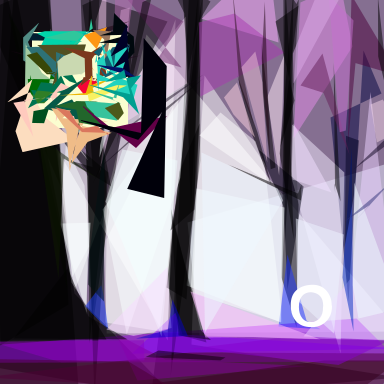

gray wool coat with a faux fur collar
[
  0.7674102297911265,
  0.7994056771201876,
  0.6615056991577148,
  1.0,
  [
    {
      "question": "What color is the coat?",
      "choices": {
        "blue": 0.0002714308938911476,
        "brown": 0.00024424607341797314,
        "gray": 0.9993488162411656,
        "red": 0.00013550679152527528
      },
      "answer": "gray",
      "pred_description": ""
    },
    {
      "question": "What part of the coat has faux fur?",
      "choices": {
        "collar": 0.997151406303566,
        "hem": 0.0007306363055033463,
        "pockets": 0.0001605361884859322,
        "sleeves": 0.001957421202444655
      },
      "answer": "collar",
      "pred_description": ""
    },
    {
      "question": "Is the coat purple?",
      "choices": {
        "no": 0.9998378343296201,
        "yes": 0.00016216567037982942
      },
      "answer": "no",
      "pred_description": ""
    },
    {
      "question": "What material is the coat made of?",
      "choice

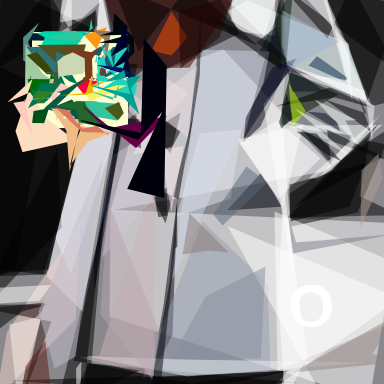

a lighthouse overlooking the ocean
[
  0.9077485233776267,
  0.9916548418997511,
  0.6782089233398437,
  1.0,
  [
    {
      "question": "Is there an ocean visible in the image?",
      "choices": {
        "no": 0.0046835442132439785,
        "yes": 0.995316455786756
      },
      "answer": "yes",
      "pred_description": ""
    },
    {
      "question": "What is the spatial relationship between the lighthouse and the ocean?",
      "choices": {
        "inside": 0.00027781718306131765,
        "next to": 0.0003870724708861182,
        "overlooking": 0.999188184931711,
        "under": 0.00014692541434158937
      },
      "answer": "overlooking",
      "pred_description": ""
    },
    {
      "question": "Is there a desert in the image?",
      "choices": {
        "no": 0.995094840806285,
        "yes": 0.004905159193715016
      },
      "answer": "no",
      "pred_description": ""
    },
    {
      "question": "Is the lighthouse located under the ocean?",
      "choices": {


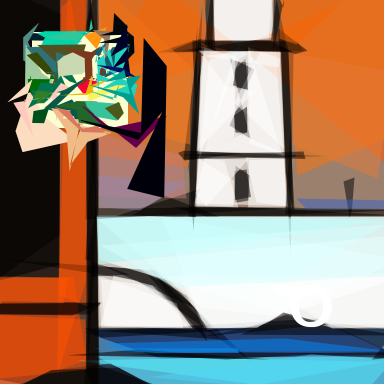

burgundy corduroy pants with patch pockets and silver buttons
[
  0.7426268484667475,
  0.7768586187354678,
  0.6313472270965577,
  1.0,
  [
    {
      "question": "Are the pants yellow?",
      "choices": {
        "no": 0.9998696567849186,
        "yes": 0.00013034321508138344
      },
      "answer": "no",
      "pred_description": ""
    },
    {
      "question": "Do the pants have patch pockets?",
      "choices": {
        "no": 0.8902199664011426,
        "yes": 0.10978003359885731
      },
      "answer": "yes",
      "pred_description": ""
    },
    {
      "question": "Are the pants burgundy?",
      "choices": {
        "no": 0.0009698386729698034,
        "yes": 0.9990301613270302
      },
      "answer": "yes",
      "pred_description": ""
    },
    {
      "question": "What item of clothing is depicted?",
      "choices": {
        "dress": 0.0005436939399431252,
        "pants": 0.9987546232310652,
        "shirt": 0.00033367777811482604,
        "skirt": 0.000368005

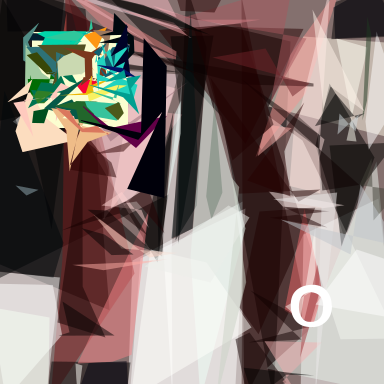

orange corduroy overalls
[
  0.7622102702606615,
  0.7992477676544655,
  0.6430191040039063,
  1.0,
  [
    {
      "question": "What material is the item?",
      "choices": {
        "corduroy": 0.9990473913133939,
        "denim": 0.0002958160274697553,
        "leather": 0.0002472883679855996,
        "silk": 0.0004095042911506951
      },
      "answer": "corduroy",
      "pred_description": ""
    },
    {
      "question": "Is a hat depicted?",
      "choices": {
        "no": 0.9852658742355833,
        "yes": 0.0147341257644167
      },
      "answer": "no",
      "pred_description": ""
    },
    {
      "question": "Is the item made of corduroy?",
      "choices": {
        "no": 0.20176227259737037,
        "yes": 0.7982377274026297
      },
      "answer": "yes",
      "pred_description": ""
    },
    {
      "question": "What type of clothing is shown?",
      "choices": {
        "a dress": 0.007291775875028304,
        "a skirt": 0.003149730571858541,
        "a suit":

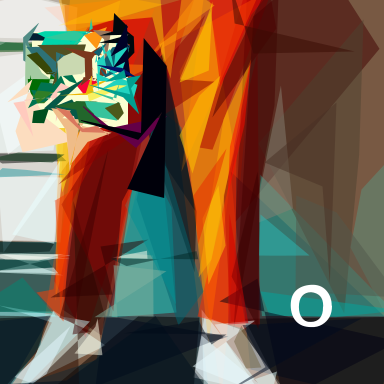

a purple silk scarf with tassel trim
[
  0.7408347734314596,
  0.7492400862549736,
  0.7090184211730957,
  1.0,
  [
    {
      "question": "Is there any purple item present in the image?",
      "choices": {
        "no": 0.00021387338040375172,
        "yes": 0.9997861266195962
      },
      "answer": "yes",
      "pred_description": ""
    },
    {
      "question": "Is a scarf depicted?",
      "choices": {
        "no": 0.0016739446219858315,
        "yes": 0.9983260553780142
      },
      "answer": "yes",
      "pred_description": ""
    },
    {
      "question": "What kind of trim does the scarf have?",
      "choices": {
        "beaded": 0.000308658533532191,
        "fringe": 0.9990069039844252,
        "lace": 0.0003874028214418133,
        "tassel": 0.0002970346606007933
      },
      "answer": "tassel",
      "pred_description": ""
    },
    {
      "question": "What color is the scarf?",
      "choices": {
        "green": 0.00026897399028069966,
        "orange": 0.

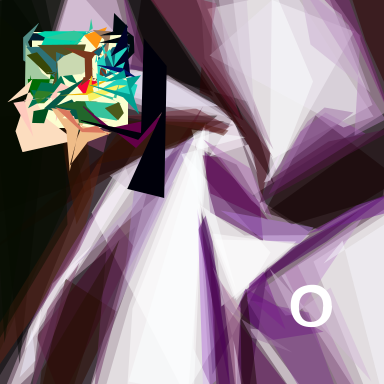

a green lagoon under a cloudy sky
[
  0.597032131859852,
  0.5745064979617002,
  0.7080842971801757,
  1.0,
  [
    {
      "question": "Is the lagoon depicted as green?",
      "choices": {
        "no": 0.7009737922354075,
        "yes": 0.2990262077645926
      },
      "answer": "yes",
      "pred_description": ""
    },
    {
      "question": "Is there a lagoon present in the image?",
      "choices": {
        "no": 0.001782458084812575,
        "yes": 0.9982175419151874
      },
      "answer": "yes",
      "pred_description": ""
    },
    {
      "question": "What is above the lagoon?",
      "choices": {
        "ceiling": 0.00022242540507088192,
        "roof": 0.0002395946671079803,
        "sky": 0.9993578815229112,
        "trees": 0.00018009840490997971
      },
      "answer": "sky",
      "pred_description": ""
    },
    {
      "question": "What body of water is depicted in the image?",
      "choices": {
        "lagoon": 0.0014243606441095213,
        "mountain": 

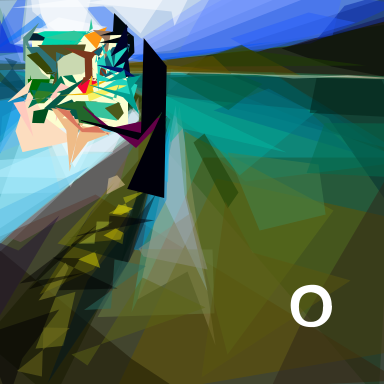

crimson rectangles forming a chaotic grid
[
  0.8837566432014107,
  0.9803395585115154,
  0.6339356422424316,
  1.0,
  [
    {
      "question": "Is the grid's arrangement chaotic?",
      "choices": {
        "no": 0.002182530176054097,
        "yes": 0.9978174698239459
      },
      "answer": "yes",
      "pred_description": ""
    },
    {
      "question": "Are the shapes primarily ovals?",
      "choices": {
        "no": 0.9998359315799527,
        "yes": 0.0001640684200473373
      },
      "answer": "no",
      "pred_description": ""
    },
    {
      "question": "Is there a single large circle present?",
      "choices": {
        "no": 0.9241456562066892,
        "yes": 0.07585434379331076
      },
      "answer": "no",
      "pred_description": ""
    },
    {
      "question": "Are the primary shapes rectangles?",
      "choices": {
        "no": 0.00044082356452616775,
        "yes": 0.9995591764354739
      },
      "answer": "yes",
      "pred_description": ""
    }
  

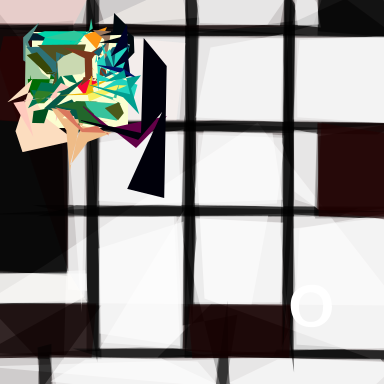

purple pyramids spiraling around a bronze cone
[
  0.6271212301158569,
  0.6143717964842192,
  0.6838894844055176,
  1.0,
  [
    {
      "question": "Is the cone made of a bronze-like material?",
      "choices": {
        "no": 0.5944979988995617,
        "yes": 0.4055020011004384
      },
      "answer": "yes",
      "pred_description": ""
    },
    {
      "question": "Are the purple objects pyramid-shaped?",
      "choices": {
        "no": 0.0010160693459281584,
        "yes": 0.9989839306540719
      },
      "answer": "yes",
      "pred_description": ""
    },
    {
      "question": "What object is at the center of the spiral?",
      "choices": {
        "cone": 0.0669068778723156,
        "cube": 0.0024549122768438318,
        "pyramid": 0.014021140230889524,
        "sphere": 0.916617069619951
      },
      "answer": "cone",
      "pred_description": ""
    },
    {
      "question": "What objects are spiraling around the cone?",
      "choices": {
        "cubes": 0.0017

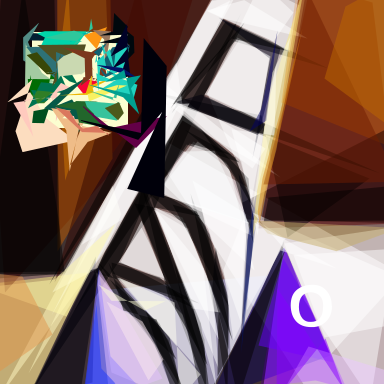

magenta trapezoids layered on a transluscent silver sheet
[
  0.7008327914956987,
  0.7154374924683463,
  0.6479265689849854,
  1.0,
  [
    {
      "question": "Is the color silver present in the image?",
      "choices": {
        "no": 0.1312110102102032,
        "yes": 0.8687889897897968
      },
      "answer": "yes",
      "pred_description": ""
    },
    {
      "question": "Which word describes the silver sheet's ability to let light through?",
      "choices": {
        "opaque": 0.00022937396758622246,
        "reflective": 0.999250735543138,
        "solid": 0.00015166452260507565,
        "translucent": 0.0003682259666706336
      },
      "answer": "translucent",
      "pred_description": ""
    },
    {
      "question": "Are the trapezoids layered on something?",
      "choices": {
        "no": 0.0006929959020985356,
        "yes": 0.9993070040979015
      },
      "answer": "yes",
      "pred_description": ""
    },
    {
      "question": "What shape are the magenta 

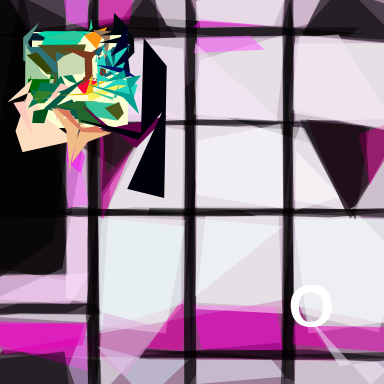

a snowy plain
[
  0.7557222215009579,
  0.7603751327204956,
  0.7376664161682129,
  1.0,
  [
    {
      "question": "What covers the plain?",
      "choices": {
        "grass": 0.0002088852950950276,
        "sand": 0.0001873114072706624,
        "snow": 0.9994936691962547,
        "water": 0.00011013410137963224
      },
      "answer": "snow",
      "pred_description": ""
    },
    {
      "question": "What is the main geographical feature depicted?",
      "choices": {
        "forest": 0.13888490810875773,
        "mountain": 0.8183668982646131,
        "ocean": 0.0003378231764225056,
        "plain": 0.04241037045020676
      },
      "answer": "plain",
      "pred_description": ""
    },
    {
      "question": "Is the plain covered in lava?",
      "choices": {
        "no": 0.9998259791651768,
        "yes": 0.00017402083482323774
      },
      "answer": "no",
      "pred_description": ""
    },
    {
      "question": "Is the plain snowy?",
      "choices": {
        "no":

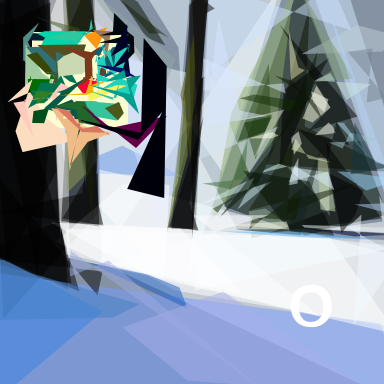

black and white checkered pants
[
  0.6733045903420256,
  0.6710392926413737,
  0.6825208187103271,
  1.0,
  [
    {
      "question": "What is the other color in the checkered pattern besides black?",
      "choices": {
        "orange": 0.00023115304190609787,
        "pink": 0.00020481387085105913,
        "white": 0.9994459239536884,
        "yellow": 0.00011810913355449497
      },
      "answer": "white",
      "pred_description": ""
    },
    {
      "question": "Is the item of clothing a pair of pants?",
      "choices": {
        "no": 0.9994184456961376,
        "yes": 0.0005815543038624516
      },
      "answer": "yes",
      "pred_description": ""
    },
    {
      "question": "Is brown part of the pattern?",
      "choices": {
        "no": 0.6843762992573492,
        "yes": 0.3156237007426507
      },
      "answer": "no",
      "pred_description": ""
    },
    {
      "question": "What is one of the colors of the checkered pattern?",
      "choices": {
        "black

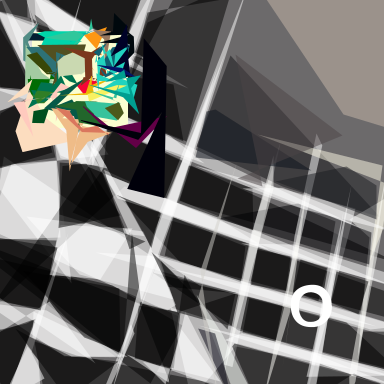

a starlit night over snow-covered peaks
[
  0.4210360406317463,
  0.3796766346349036,
  0.7461645126342773,
  1.0,
  [
    {
      "question": "Is the image depicting a nighttime scene?",
      "choices": {
        "no": 0.9976217591423859,
        "yes": 0.0023782408576140278
      },
      "answer": "yes",
      "pred_description": ""
    },
    {
      "question": "Is the image depicting a daytime scene?",
      "choices": {
        "no": 0.23099029699384324,
        "yes": 0.7690097030061568
      },
      "answer": "no",
      "pred_description": ""
    },
    {
      "question": "Are there peaks visible in the image?",
      "choices": {
        "no": 0.0007734247142612113,
        "yes": 0.9992265752857388
      },
      "answer": "yes",
      "pred_description": ""
    },
    {
      "question": "Is the night sky depicted as cloudy?",
      "choices": {
        "no": 0.2861114254024184,
        "yes": 0.7138885745975816
      },
      "answer": "no",
      "pred_description": "

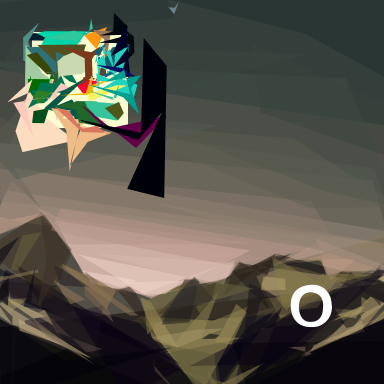

khaki triangles and azure crescents
[
  0.48983890405904296,
  0.45719031552993866,
  0.6857084274291992,
  1.0,
  [
    {
      "question": "Are there any azure colored spirals?",
      "choices": {
        "no": 0.0009364103514802454,
        "yes": 0.9990635896485197
      },
      "answer": "no",
      "pred_description": ""
    },
    {
      "question": "Are there any crescent shapes present?",
      "choices": {
        "no": 0.2107581954025564,
        "yes": 0.7892418045974436
      },
      "answer": "yes",
      "pred_description": ""
    },
    {
      "question": "What color are some of the shapes?",
      "choices": {
        "black": 0.001207943895981251,
        "khaki": 0.040457982499390394,
        "orange": 0.00035711879655138905,
        "white": 0.957976954808077
      },
      "answer": "khaki",
      "pred_description": ""
    },
    {
      "question": "What shape are some of the khaki forms?",
      "choices": {
        "circles": 0.00040370476158232716,
      

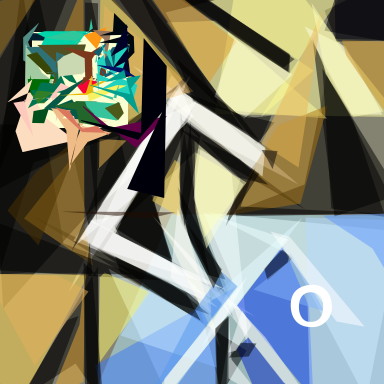

a maroon dodecahedron interwoven with teal threads
[
  0.6424680263458279,
  0.6663555539990449,
  0.5618965148925781,
  1.0,
  [
    {
      "question": "Are the threads colored pink?",
      "choices": {
        "no": 0.6653187482215738,
        "yes": 0.3346812517784262
      },
      "answer": "no",
      "pred_description": ""
    },
    {
      "question": "Is there a triangle interwoven with teal threads?",
      "choices": {
        "no": 0.0006538959492540508,
        "yes": 0.999346104050746
      },
      "answer": "no",
      "pred_description": ""
    },
    {
      "question": "Is there anything maroon in the image?",
      "choices": {
        "no": 0.0003163113777309875,
        "yes": 0.999683688622269
      },
      "answer": "yes",
      "pred_description": ""
    },
    {
      "question": "Are there any teal elements in the image?",
      "choices": {
        "no": 0.00023411679691736083,
        "yes": 0.9997658832030827
      },
      "answer": "yes",
      "pred

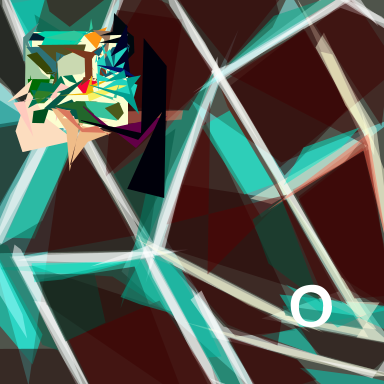

In [33]:
for description, svg, score in zip(train_df["description"], submission["svg"], all_scores):
    img = svg_to_png(svg)
    print(description)
    print(json.dumps(score, indent=2))
    display(img)